In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
shuffle_seed = 2023
df_train = pd.read_csv(f'/data/hyogun/repos/epic-kitchens-100-annotations/EPIC_100_train.csv')
df_valid = pd.read_csv(f'/data/hyogun/repos/epic-kitchens-100-annotations/EPIC_100_validation.csv')
df_train = df_train[df_train['participant_id'].isin(['P02', 'P04', 'P22'])]
df_valid = df_valid[df_valid['participant_id'].isin(['P02', 'P04', 'P22'])]
df_whole = pd.concat([df_train, df_valid], ignore_index=True)
df_whole = df_whole[df_whole['video_id'] != 'P04_30']
train_dfs, valid_dfs = [], []
for verb_class in range(df_whole['verb_class'].max()):
    for participant in ['P02', 'P04', 'P22']:
        df_tmp = df_whole[
            (df_whole['participant_id']==participant)
            & (df_whole['verb_class']==verb_class)
        ]
        num_train = int(df_tmp.shape[0] * .8)
        train_dfs.append(df_tmp[:num_train])
        valid_dfs.append(df_tmp[num_train:])
df_train = pd.concat(train_dfs, ignore_index=True).sample(frac=1, random_state=shuffle_seed)
df_valid = pd.concat(valid_dfs, ignore_index=True).sample(frac=1, random_state=shuffle_seed)
df_train

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
17927,P04_112_120,P04,P04_112,00:03:24.355,00:03:23.47,00:03:24.66,10173,10233,scrunch up coriander packet,scrunch-up,18,packet:coriander,26,['packet:coriander'],[26]
15071,P22_109_100,P22,P22_109,00:03:20.350,00:03:19.84,00:03:20.50,9992,10025,turn off tap,turn-off,8,tap,0,['tap'],[0]
4613,P02_06_359,P02,P02_06,00:16:35.319,00:16:35.47,00:16:35.97,59728,59758,put knife,put,1,knife,4,['knife'],[4]
3422,P22_109_530,P22,P22_109,00:22:56.905,00:22:56.63,00:22:57.22,68831,68861,pick up jar,pick-up,0,jar,40,['jar'],[40]
11966,P02_126_44,P02,P02_126,00:02:00.404,00:02:00.38,00:02:01.17,6019,6058,close drawer,close,4,drawer,8,['drawer'],[8]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,P22_08_384,P22,P22_08,00:15:18.870,00:15:17.48,00:15:19.60,55048,55176,put down coffee cup,put-down,1,cup:coffee,13,['cup:coffee'],[13]
5852,P04_107_912,P04,P04_107,00:23:46.853,00:23:47.52,00:23:48.35,71376,71417,put on oven gloves,put-on,1,glove:oven,60,['glove:oven'],[60]
6049,P04_112_256,P04,P04_112,00:08:05.603,00:08:04.81,00:08:05.86,24240,24293,put down cheese,put-down,1,cheese,32,['cheese'],[32]
19127,P22_113_135,P22,P22_113,00:04:43.419,00:04:29.58,00:04:50.30,13479,14515,tap spatula,tap,32,spatula,20,['spatula'],[20]


# P04_30 딱 하나 없음

In [4]:
import os
video_ids = '/data/dataset/epic-kitchens-100/EPIC-KITCHENS/' + df_valid['participant_id'] + '/rgb_frames/' + df_valid['video_id']
video_ids = video_ids.unique()
isdir = np.vectorize(lambda x: os.path.isdir(x))(video_ids)
x = pd.Series(isdir, index=video_ids)
with pd.option_context('max_colwidth', -1, 'display.max_rows', 1000):
    print(x[~x])

Series([], dtype: bool)


In [5]:
ann_map = pd.read_csv('/data/hyogun/repos/epic-kitchens-100-annotations/EPIC_100_verb_classes.csv').set_index('id')
ann_map

,key,instances,category
id,,,
0,take,"['collect-from', 'collect-into', 'draw', 'fetc...",retrieve
1,put,"['create', 'dose', 'lay', 'lay-down', 'lay-on'...",leave
2,wash,"['clean', 'clean-around', 'clean-from', 'clean...",clean
3,open,"['lever-open', 'open', 'open-in', 'open-on', '...",access
4,close,"['close', 'close-off', 'close-with', 'screw-on...",block
...,...,...,...
92,prepare,"['prepare', 'prepare-for']",manipulate
93,bake,['bake'],manipulate
94,mark,"['mark', 'mark-on']",manipulate


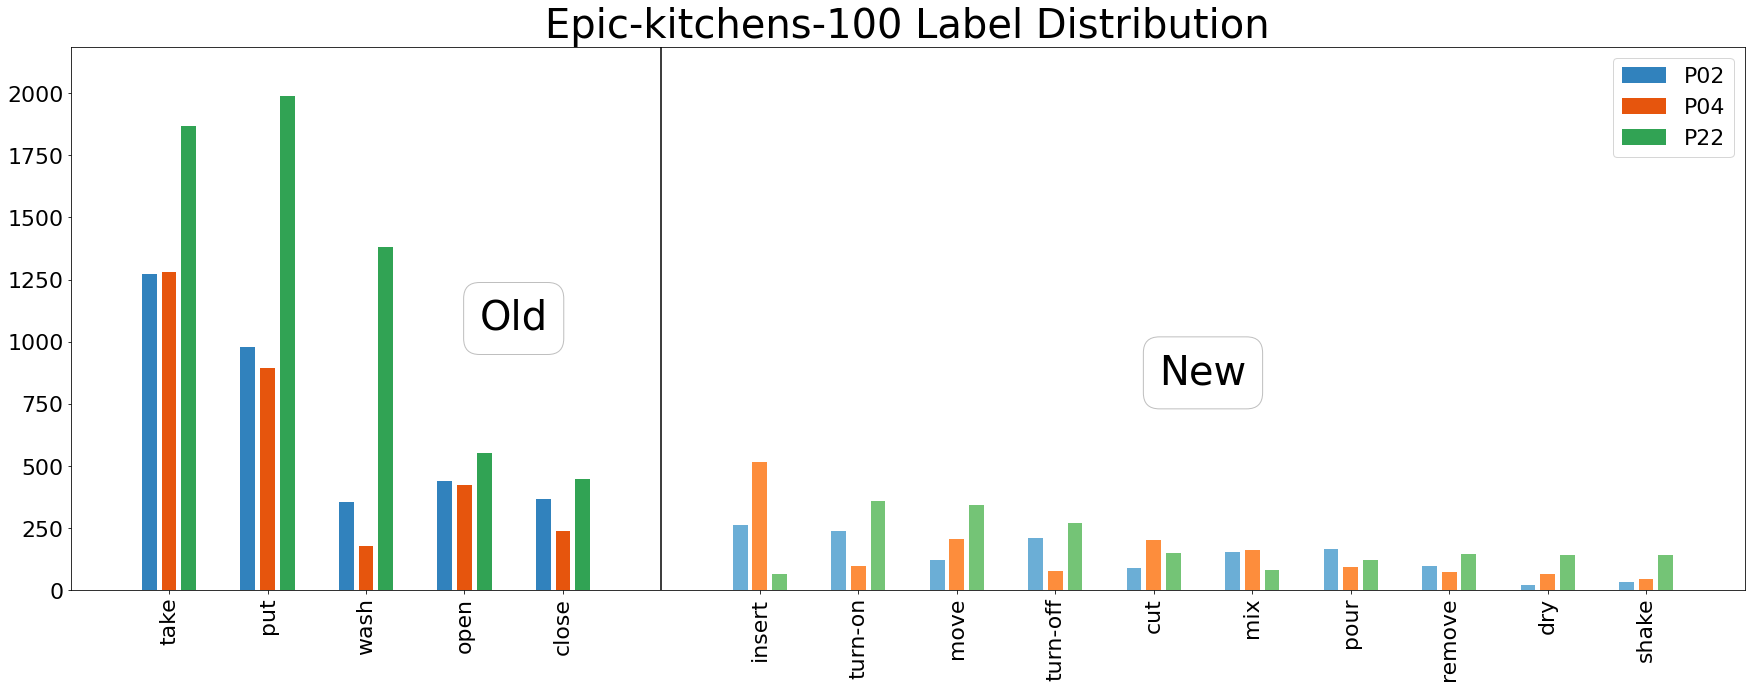

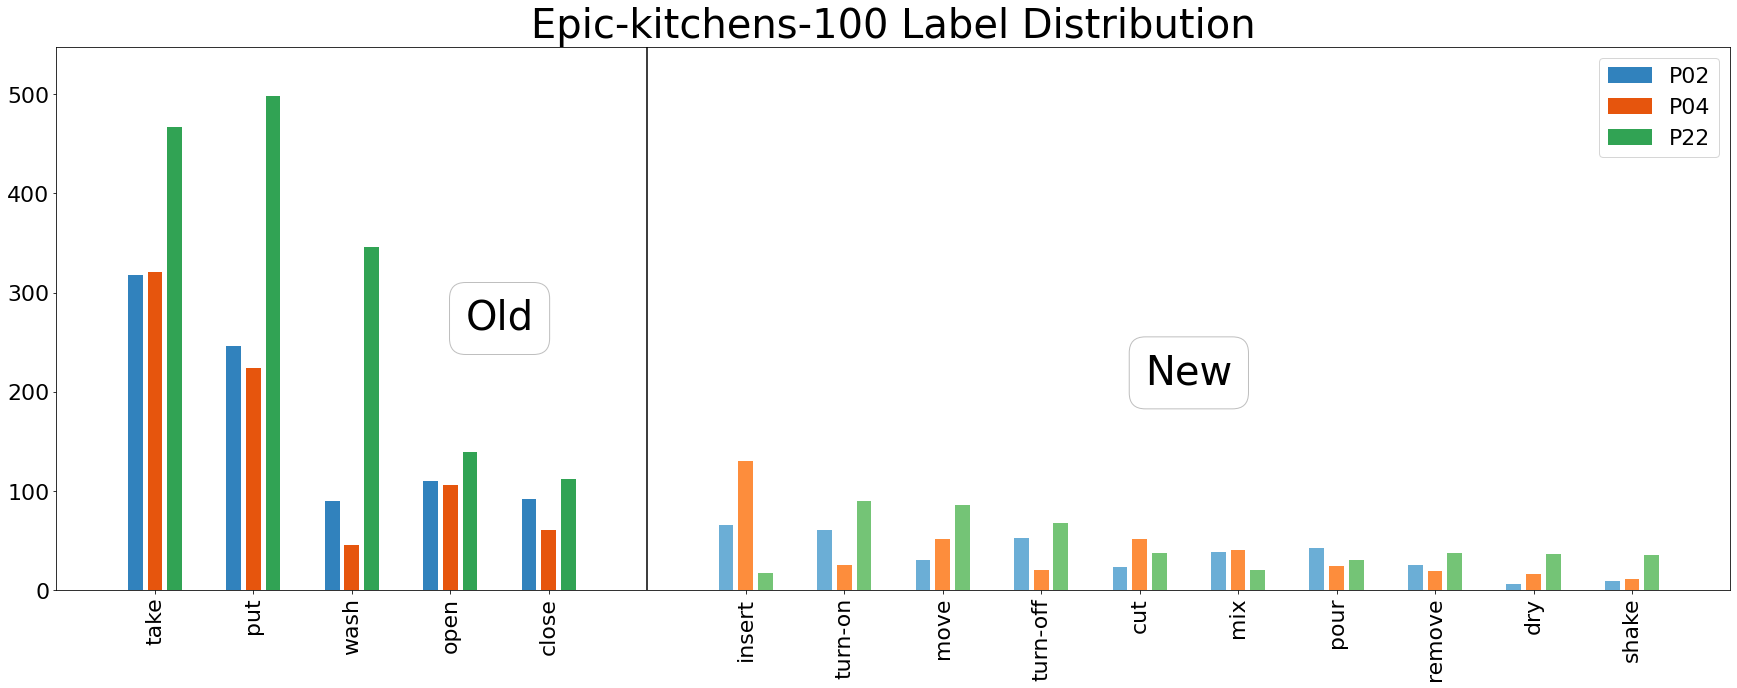

In [6]:
num_old_classes = 5
num_all_classes = 15
width = .15
margin = .05
total_common = df_train['verb_class'].value_counts()[:num_all_classes]
ticklabels = [ann_map.loc[i]['key'] for i in total_common.index]
for df in [df_train, df_valid]:
    fig = plt.figure(figsize=(30, 10))
    ax = fig.gca() 
    global_xticks = np.arange(num_all_classes)
    global_xticks[num_old_classes:] += 1
    ax.set_xticks(global_xticks)
    ax.set_xticklabels(ticklabels, rotation=90, ha='center', va='top', fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_xlim(global_xticks[0]-1, global_xticks[-1]+1)
    plt.title('Epic-kitchens-100 Label Distribution', fontsize=40)
    cmap = plt.get_cmap('tab20c')
    ncolors = 5
    nlevels = 4
    step_color = 1 / ncolors
    step_level = step_color / nlevels
    offset = step_level / 2
    ylim = -1
    for i, participant in enumerate(['P02', 'P04', 'P22']):
        xticks = global_xticks + (i-1)*(width+margin)
        common = df[df['participant_id']==participant]['verb_class'].value_counts()
        common = np.array([common.get(index, 0) for index in total_common.index])
        ylim = max(ylim, common.max())
        assert common.shape[0] == num_all_classes
        color = cmap(offset + (i+0)*step_color)
        ax.bar(xticks[:num_old_classes], common[:num_old_classes], width=width, color=color, label=participant)
        color = cmap(offset + (i+0)*step_color + 1*step_level)
        ax.bar(xticks[num_old_classes:], common[num_old_classes:], width=width, color=color)
    ylim *= 1.1
    ax.set_ylim(0, ylim)
    ax.plot((num_old_classes, num_old_classes), (0, ylim), c='k')
    text = ax.text(num_old_classes/2+1, ylim*.5, 'Old', ha='center', va='center', fontsize=40)
    text.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round,pad=.4'))
    text.set_zorder(-1)
    text = ax.text(num_old_classes + (num_all_classes-num_old_classes+1)/2, ylim*.4, 'New', ha='center', va='center', fontsize=40)
    text.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round,pad=.4'))
    text.set_zorder(-1)
    plt.legend(fontsize=22)
    plt.show() 

In [9]:
df_valid

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,length,p_video,verb_class_cdar
3852,P02_12_284,P02,P02_12,00:17:15.230,00:17:13.11,00:17:14.36,61986,62061,pour oil,pour,9,oil,31,['oil'],[31],76,P02/rgb_frames/P02_12,7
4680,P22_04_71,P22,P22_04,00:02:16.000,00:02:12.30,00:02:16.84,7938,8210,turn knife,turn,23,knife,4,['knife'],[4],273,P22/rgb_frames/P22_04,-1
4823,P02_130_211,P02,P02_130,00:08:11.651,00:08:11.00,00:08:12.46,24550,24623,hit spoon on side of bowl,hit-on,32,spoon,1,"['spoon', 'side:bowl']","[1, 7]",74,P02/rgb_frames/P02_130,-1
1393,P04_120_44,P04,P04_120,00:02:37.102,00:02:36.90,00:02:39.40,7845,7970,put down tablet packet,put-down,1,packet:tablet,26,['packet:tablet'],[26],126,P04/rgb_frames/P04_120,1
3658,P22_01_182,P22,P22_01,00:09:59.410,00:09:52.72,00:09:54.72,35563,35683,cut peach,cut,7,peach,74,['peach'],[74],121,P22/rgb_frames/P22_01,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,P04_121_353,P04,P04_121,00:15:57.850,00:15:56.33,00:15:57.15,47816,47857,pick up bowl,pick-up,0,bowl,7,['bowl'],[7],42,P04/rgb_frames/P04_121,0
4148,P22_17_463,P22,P22_17,00:18:09.999,00:18:08.82,00:18:09.83,65329,65389,move spoon,move,11,spoon,1,['spoon'],[1],61,P22/rgb_frames/P22_17,9
884,P22_01_214,P22,P22_01,00:11:22.800,00:11:20.94,00:11:23.19,40856,40991,pick up plate,pick-up,0,plate,2,['plate'],[2],136,P22/rgb_frames/P22_01,0
2743,P04_24_43,P04,P04_24,00:04:12.069,00:04:34.30,00:04:34.88,16458,16492,open coconut powder,open,3,powder:coconut,196,['powder:coconut'],[196],35,P04/rgb_frames/P04_24,3


In [5]:
num_old_classes = 5
num_all_classes = 15
p_target_root = Path('/data/hyogun/repos/haawron_mmaction2/data/_filelists/ek100/processed')
total_common = df_train['verb_class'].value_counts()[:num_all_classes]
closed_class_index = total_common.index[:num_old_classes]
open_class_index = total_common.index 
index_map = {i_cdar: i_official for i_official, i_cdar in enumerate(open_class_index)}

df_train['length'] = df_train['stop_frame'] - df_train['start_frame'] + 1
df_train['p_video'] = df_train['participant_id'] + '/rgb_frames/' + df_train['video_id']
df_train['verb_class_cdar'] = (df_train['verb_class'].map(index_map).fillna(-1)).astype(int)
df_valid['length'] = df_valid['stop_frame'] - df_valid['start_frame'] + 1
df_valid['p_video'] = df_valid['participant_id'] + '/rgb_frames/' + df_valid['video_id']
df_valid['verb_class_cdar'] = (df_valid['verb_class'].map(index_map).fillna(-1)).astype(int)
for participant in ['P02', 'P04', 'P22']:
    for splitname in [
          'train_closed', 'train_open_all',
          'test_closed', 'test_merged_open_all'
    ]:
        is_closed = 'closed' in splitname
        num_classes_thres = num_old_classes if is_closed else num_all_classes
        df = df_train if 'train' in splitname else df_valid
        df_participant = df.loc[(
            df['participant_id']==participant)
            & (df['verb_class_cdar'] < num_classes_thres)
            & (df['verb_class_cdar'] >= 0)]
        df_participant = df_participant.sample(frac=1, random_state=shuffle_seed).reset_index()
        df_participant = df_participant[['p_video', 'start_frame', 'length', 'verb_class_cdar']]
        p_filelist_out = p_target_root/f'filelist_{participant}_{splitname}.txt'
        df_participant.to_csv(p_filelist_out, sep=' ', header=False, index=False)
        print(f'{p_filelist_out.name:40} {df_participant.shape[0]}')

filelist_P02_train_closed.txt            3415
filelist_P02_train_open_all.txt          4810
filelist_P02_test_closed.txt             856
filelist_P02_test_merged_open_all.txt    1212
filelist_P04_train_closed.txt            3017
filelist_P04_train_open_all.txt          4555
filelist_P04_test_closed.txt             758
filelist_P04_test_merged_open_all.txt    1148
filelist_P22_train_closed.txt            6237
filelist_P22_train_open_all.txt          8061
filelist_P22_test_closed.txt             1562
filelist_P22_test_merged_open_all.txt    2023


In [ ]:
index_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 11,
 8: 8,
 9: 7,
 10: 10,
 11: 9,
 12: 12,
 13: 14,
 14: 15}